# Topic Modelling

It is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words in large clusters of texts.

Topic Models are very useful for the purpose for document clustering, organizing large blocks of textual data, information retrieval from unstructured text and feature selection.

#### Tasks to perform 
- Preparing documents
- Cleaning and Preprocessing
- Preparing document term matrix
- Running LDA(Latent Dirichlet Allocation) model
- Improve results


## Preparing documents

Passage is taken from https://www.learncbse.in/unseen-passage-for-class-7/

#### Previous topic modelling output is not satisfactory

We have to add full passages and try to make our model do the guess work on Topic of passage.

We will check if our model will pass english unseen passage exam and answer the questions students have to answer.

In [1]:
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))
display_gif('tenor.gif')

## Currently this model is not the most accurate bcoz it has not been trained with a big corpora.

Our aim now is to improve it by feeding more training data. All of us students had read way too much than this model so of course we will be better than this model for now :)

# Let the web scraping begin!!!

from the site- https://www.indiacelebrating.com/essay/black-money-essay/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [3]:
import urllib
import requests
import re
from nltk.stem import WordNetLemmatizer
from gensim.models import LdaModel, TfidfModel
from gensim.corpora.dictionary import Dictionary

In [4]:
url="https://www.indiacelebrating.com/essay/black-money-essay/"
req = urllib.request.urlopen(url)

In [5]:
soup = BeautifulSoup(req,'lxml')

In [6]:
type(soup)

bs4.BeautifulSoup

In [7]:
# prettify() gives HTML text of the page
# print(soup.prettify())
soup.find('title')

<title>Long and Short Essay on Black Money in English for Children and Students</title>

In [8]:
soup.find_all('h3')

[<h3>Black Money Essay – 1 (200 words)</h3>,
 <h3>Black Money Essay – 2 (300 words)</h3>,
 <h3>Black Money Essay – 3 (400 words)</h3>,
 <h3>Black Money Essay – 4 (500 words)</h3>,
 <h3>Black Money Essay – 5 (600 words)</h3>,
 <h3>About The Author</h3>,
 <h3>Related Posts</h3>]

In [9]:
#Gives all the text which exists between tags
#print(soup.get_text())

Clearly what we are getting from get_text is gibberish and if we start cleaning it then this exercise will be of no use. ** Our aim is to get Topic without mentioning topic anywhere.**

In [10]:
link = requests.get("https://www.indiacelebrating.com/essay/black-money-essay/")

In [11]:
#link = requests.get("https://www.indiacelebrating.com/essay/b")

In [12]:
link

<Response [200]>

In [13]:
# prints html content
#print(link.content)

In [14]:
# prints pretty HTML
#print(link.text)

This is insane! I was not expecting it to be filled it with so much junk. Let us stick with urllib for now.

So there is a pattern in this page. all < p > under < div class= "post-content entry-content" > are our area of interest along with some google ads. We will add those in stopwords. 
I have 2 approaches here-
1. get all p's 
2. get div with class= "post-content entry-content"

I will try first with the one with all p's.

In [15]:
ch = soup.children
type(ch)

# ch has list of all child tags of html page

#for i in ch:
#    print(i)

list_iterator

In [16]:
par = soup.find(name = 'div', attrs="post-content entry-content")

print(len(par))
#print(par) 
#instead of taking this parent we will take all p's

84


In [17]:
paras = par.find_all('p')

In [18]:
#paras = soup.find_all(name='p')

In [19]:
paras[:2]

[<p>Black money is basically the accumulation of income obtained illegally. It is not declared for tax purpose. The issue of black money is prevalent in India and the government has come up with stern measures to deal with it lately. The money earned via unlawful means is known as black money. There are various sources of generating black money and people have been practicing these since decades despite the negative impact they have on the society.</p>,
 <p>Here are essays on Black Money of varying lengths to help you with the topic in your exam, class tests or competitions. You can choose any Black Money essay according to your need and interest:</p>]

We will get data between < p > and < /p >. As type of each element of paras is tag, that means we can get text from it :)

In [20]:
type(paras[0])
#re.sub('^<p></p>$', '', paras[0])

bs4.element.Tag

In [21]:
paras[0].get_text()

'Black money is basically the accumulation of income obtained illegally. It is not declared for tax purpose. The issue of black money is prevalent in India and the government has come up with stern measures to deal with it lately. The money earned via unlawful means is known as black money. There are various sources of generating black money and people have been practicing these since decades despite the negative impact they have on the society.'

I will subject all the data coming from this url as 1 document. So all text coming from p's will be appended and added as 1 row in df. We have more data coming from other url's right after we figure this one out.

In [22]:
Document_text=''

for p in paras[:2]:
    print(p.get_text())

Black money is basically the accumulation of income obtained illegally. It is not declared for tax purpose. The issue of black money is prevalent in India and the government has come up with stern measures to deal with it lately. The money earned via unlawful means is known as black money. There are various sources of generating black money and people have been practicing these since decades despite the negative impact they have on the society.
Here are essays on Black Money of varying lengths to help you with the topic in your exam, class tests or competitions. You can choose any Black Money essay according to your need and interest:


Looks like it will need some cleaning. Nevermind. We will put it to df.

In [23]:
Document_text=''

for p in paras:
    Document_text+=p.get_text().strip('\n')+' '

In [24]:
Document_text[:100]

'Black money is basically the accumulation of income obtained illegally. It is not declared for tax p'

In [25]:
#Document_text[9500:]
#s=re.sub('\n*\_*', '', Document_text)
#s[10500:]
#re.sub('<!--[a-zA-Z0-9]*?-->', '', s)

In [26]:
# removing anything between html comment tags
#s=re.sub('<!--(.*?)-->', '',Document_text)
#s[9500:]

Yup. This successfully removes our comments. (This one is not having comments but previous < p >'s had and this worked perfectly fine there).

Time to put it all together in dataFrame df.

#### Getting list of essays

All td elements have links to essays. So we will get our essay list from there.

In [27]:
home_url = 'https://www.indiacelebrating.com/english-essay/'
home_page = urllib.request.urlopen(home_url)

In [28]:
soup = BeautifulSoup(home_page, 'lxml')
#soup

In [29]:
tds = soup.find_all('td')
tds[:5]

[<td align="LEFT" bgcolor="#CCCCCC" height="17" width="255"><strong>General Essay<br/>
 </strong></td>,
 <td align="LEFT" bgcolor="#CCCCCC" width="177"></td>,
 <td align="LEFT" height="17" width="255"><a href="https://www.indiacelebrating.com/essay/generation-gap-essay/">Essay on Generation Gap</a></td>,
 <td align="LEFT" width="177"><a href="https://www.indiacelebrating.com/essay/globalization-essay/">Globalization Essay</a></td>,
 <td align="LEFT" height="17" width="255"><a href="https://www.indiacelebrating.com/essay/music-essay/">Essay on Music</a></td>]

In [30]:
print('tds[2]:: ',tds[2])
print('\ntype(tds[2]):: '.ljust(15), type(tds[2]))
print('\ntype(tds[2].contents):: '.ljust(15), type(tds[2].contents))
for d in tds[2].children:
    print('\n', type(d), d.attrs)

tds[2]::  <td align="LEFT" height="17" width="255"><a href="https://www.indiacelebrating.com/essay/generation-gap-essay/">Essay on Generation Gap</a></td>

type(tds[2])::  <class 'bs4.element.Tag'>

type(tds[2].contents)::  <class 'list'>

 <class 'bs4.element.Tag'> {'href': 'https://www.indiacelebrating.com/essay/generation-gap-essay/'}


In [31]:
essay_links = list()
for td in tds:
    for d in td.children:
        if d.attrs:
            #essay_links.append([v for v in d.attrs.values()])
            essay_links.append(d.attrs['href'])

In [32]:
essay_links[:5]

['https://www.indiacelebrating.com/essay/generation-gap-essay/',
 'https://www.indiacelebrating.com/essay/globalization-essay/',
 'https://www.indiacelebrating.com/essay/music-essay/',
 'https://www.indiacelebrating.com/essay/my-hobby-essay/',
 'https://www.indiacelebrating.com/essay/money-essay/']

In [33]:
len(essay_links)#print(essay_links[:100])

367

Considering that there might be links which are not directed to essays, we have roughly 360 essays/documents. 

We can keep 100 for training for now and take 101th for testing.

In [34]:
all_data = list()
for link in essay_links[:360]:
    essay_data = urllib.request.urlopen(link)
    soup = BeautifulSoup(essay_data, 'lxml')
    #print(soup.title)
    par = soup.find(name = 'div', attrs="post-content entry-content")
    paras = par.find_all(name='p')
    Document_text=''
    for p in paras:
        Document_text+=p.get_text().strip()+' '
        Document_text=re.sub('<!--(.*?)-->', '',Document_text )
        
    all_data.append(Document_text)

In [37]:
len(all_data)

360

In [39]:
#all_data

In [40]:
df = pd.DataFrame(all_data, columns=['Data'])
df.head()

,Data
0,Generation Gap occurs when there is a consider...
1,Globalization is the process used by businesse...
2,Music is the art of expressing ideas and emoti...
3,"Hobby is the favorite activity, habit or choic..."
4,Money is the medium used by people to buy requ...


In [41]:
df_copy=df.copy()

#### We will read back  data from df for cleaning

In [42]:
wc = WordCloud(width=1000, height=800, min_font_size=8, max_words=300)

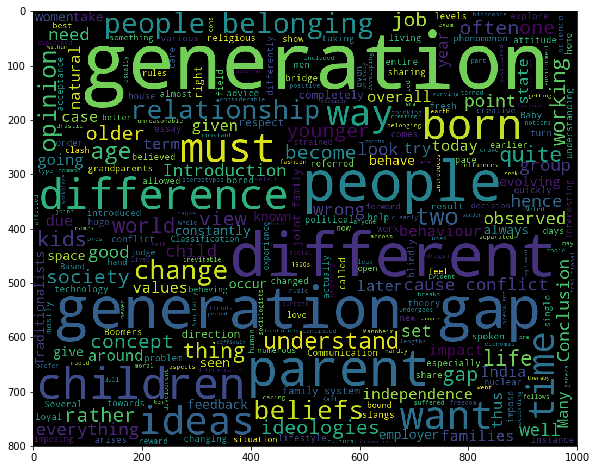

In [43]:
plt.figure(figsize=(10,8))
plt.imshow(wc.generate_from_text(df['Data'][0]))

In [72]:
#stopwords_list.extend(['select', 'page'])
#re.sub('\W+', ' ', df['Data'][0])
stopword = stopwords.words('english')
stopword.extend(['u'])
stopword[:5]

['i', 'me', 'my', 'myself', 'we']

In [73]:
lemm = WordNetLemmatizer()

def clean(doc):
    rem_punc = re.sub('\W+', ' ', doc)
    rem_stops = [word.lower() for word in rem_punc.split() if word.lower() not in stopword]
    doc_lemm = ' '.join([lemm.lemmatize(word) for word in rem_stops])
    
    return doc_lemm

In [74]:
df['Clean_Data'] = df['Data'].apply(clean)

In [75]:
df['Clean_Data'][:5]

0    generation gap occurs considerable difference ...
1    globalization process used business organizati...
2    music art expressing idea emotion significant ...
3    hobby favorite activity habit choice person re...
4    money medium used people buy required good ser...
Name: Clean_Data, dtype: object

In [76]:
df['List']=df['Clean_Data'].apply(lambda st:st.split())

In [77]:
df['List'][0][:10]

['generation',
 'gap',
 'occurs',
 'considerable',
 'difference',
 'age',
 'entire',
 'generation',
 'two',
 'people']

In [78]:
dict_df = Dictionary(df['List'])
dict_df.keys

<bound method Dictionary.keys of <gensim.corpora.dictionary.Dictionary object at 0x000001F713C5F6A0>>

In [79]:
df['bow'] = df['List'].apply(lambda x : dict_df.doc2bow(x))
df.head()

,Data,Clean_Data,List,bow
0,Generation Gap occurs when there is a consider...,generation gap occurs considerable difference ...,"[generation, gap, occurs, considerable, differ...","[(0, 2), (1, 1), (2, 1), (3, 3), (4, 3), (5, 1..."
1,Globalization is the process used by businesse...,globalization process used business organizati...,"[globalization, process, used, business, organ...","[(9, 1), (11, 1), (12, 2), (16, 3), (19, 1), (..."
2,Music is the art of expressing ideas and emoti...,music art expressing idea emotion significant ...,"[music, art, expressing, idea, emotion, signif...","[(11, 2), (21, 1), (23, 1), (24, 10), (27, 5),..."
3,"Hobby is the favorite activity, habit or choic...",hobby favorite activity habit choice person re...,"[hobby, favorite, activity, habit, choice, per...","[(11, 3), (12, 1), (17, 2), (23, 3), (24, 5), ..."
4,Money is the medium used by people to buy requ...,money medium used people buy required good ser...,"[money, medium, used, people, buy, required, g...","[(17, 1), (20, 1), (21, 2), (38, 1), (40, 4), ..."


## Running LDA using Bag of Words

In [80]:
model = LdaModel(df['bow'], id2word=dict_df)

In [82]:
model.print_topics(num_topics=5, num_words=5)

[(63,
  '0.017*"people" + 0.016*"day" + 0.013*"life" + 0.011*"india" + 0.007*"country"'),
 (44,
  '0.014*"india" + 0.010*"people" + 0.009*"life" + 0.008*"day" + 0.008*"time"'),
 (86,
  '0.012*"day" + 0.011*"resource" + 0.009*"also" + 0.009*"people" + 0.008*"festival"'),
 (7,
  '0.013*"india" + 0.012*"day" + 0.010*"country" + 0.009*"essay" + 0.008*"also"'),
 (55,
  '0.012*"right" + 0.010*"people" + 0.008*"resource" + 0.006*"india" + 0.006*"education"')]

## Running LDA using TF-IDF

In [83]:
tfidf = TfidfModel(df['bow'])
td_corpus = tfidf[df['bow']]
print(td_corpus)

In [84]:
model_tf = LdaModel(td_corpus, id2word=dict_df, num_topics=10)

In [85]:
model_tf.print_topics(num_topics=5, num_words=5)

[(2,
  '0.001*"education" + 0.001*"girl" + 0.001*"summer" + 0.001*"woman" + 0.001*"vacation"'),
 (4,
  '0.001*"cleanliness" + 0.001*"money" + 0.001*"hobby" + 0.001*"gardening" + 0.001*"bank"'),
 (1,
  '0.001*"village" + 0.001*"road" + 0.001*"pollution" + 0.001*"city" + 0.001*"mother"'),
 (8,
  '0.001*"deforestation" + 0.001*"sport" + 0.001*"flag" + 0.001*"india" + 0.001*"soil"'),
 (9,
  '0.001*"library" + 0.001*"waste" + 0.001*"health" + 0.001*"nature" + 0.001*"gandhi"')]

In [86]:
from gensim.models import CoherenceModel

In [87]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=model, texts=df['List'], dictionary=dict_df, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.264925552910915


# Okay. So our model is pretty bad. We will still test it out

In [60]:
link = essay_links[101]
essay_data = urllib.request.urlopen(link)
soup = BeautifulSoup(essay_data, 'lxml')
#print(soup.title)
par = soup.find(name = 'div', attrs="post-content entry-content")
paras = par.find_all(name='p')
Document_text=''
for p in paras:
    Document_text+=p.get_text().strip()+' '
    s=re.sub('<!--(.*?)-->', '',Document_text )
        
print(s[:100])

Social media basically means any human communication or sharing information on internet that occurs 


In [61]:
clean_test = clean(s)
clean_test[:100]

'social medium basically mean human communication sharing information internet occurs medium computer'

In [62]:
clean_test_list = clean_test.split()
clean_test_list[:10]

['social',
 'medium',
 'basically',
 'mean',
 'human',
 'communication',
 'sharing',
 'information',
 'internet',
 'occurs']

In [63]:
# taking same dictionary we will create bow
bow_test = dict_df.doc2bow(clean_test_list)

In [64]:
# LDA model on BOW
#print(sorted(model[bow_test], key=lambda tup: -1*tup[1]))
tups= sorted(model[bow_test], key=lambda tup: -1*tup[1])
for index, score in tups:
    
    print('Score: ', round(score, 3), '  Topics: ',model.print_topic(index, topn=5))

Score:  0.794   Topics:  0.015*"life" + 0.013*"people" + 0.009*"time" + 0.007*"essay" + 0.006*"india"
Score:  0.087   Topics:  0.012*"country" + 0.012*"people" + 0.009*"india" + 0.008*"also" + 0.008*"day"
Score:  0.057   Topics:  0.021*"time" + 0.012*"people" + 0.009*"life" + 0.009*"one" + 0.008*"good"
Score:  0.042   Topics:  0.010*"life" + 0.010*"india" + 0.009*"people" + 0.007*"also" + 0.006*"country"
Score:  0.017   Topics:  0.016*"people" + 0.010*"life" + 0.007*"country" + 0.007*"india" + 0.007*"also"


In [65]:
tups= sorted(model_tf[bow_test], key=lambda tup: -1*tup[1])
for index, score in tups:
    
    print('Score: ', round(score, 3), '  Topics: ',model_tf.print_topic(index, topn=5))

Score:  0.612   Topics:  0.002*"education" + 0.001*"pollution" + 0.001*"tree" + 0.001*"sport" + 0.001*"science"
Score:  0.355   Topics:  0.001*"warming" + 0.001*"global" + 0.001*"woman" + 0.001*"labour" + 0.001*"poverty"
Score:  0.032   Topics:  0.001*"knowledge" + 0.001*"plastic" + 0.001*"resource" + 0.001*"bag" + 0.001*"pollution"


## From our model the topic could have words like 
- youth, farmer, technology, science. patriotism

- country, india, education, school, people 

We will see ourselves now to check to what extent is it correct.

In [66]:
essay_links[101]

'https://www.indiacelebrating.com/essay/essay-on-social-media/'

Well topic was "Social Media" and our model again failed miserably

In [67]:
link = essay_links[100]
essay_data = urllib.request.urlopen(link)
soup = BeautifulSoup(essay_data, 'lxml')
#print(soup.title)
par = soup.find(name = 'div', attrs="post-content entry-content")
paras = par.find_all(name='p')
Document_text=''
for p in paras:
    Document_text+=p.get_text().strip()+' '
    s=re.sub('<!--(.*?)-->', '',Document_text )
        
print(s[:100])

Everyone’s life is extremely dependent on the scientific inventions and modern technology. Lives of 


In [68]:
clean_test = clean(s)
clean_test_list = clean_test.split()

In [69]:
# taking same dictionary we will create bow
bow_test = dict_df.doc2bow(clean_test_list)
tups= sorted(model[bow_test], key=lambda tup: -1*tup[1])

# LDA model on BOW
#print(sorted(model[bow_test], key=lambda tup: -1*tup[1]))
for index, score in tups:    
    print('Score: ', round(score, 3), '  Topics: ',model.print_topic(index, topn=5))

Score:  0.568   Topics:  0.017*"life" + 0.013*"people" + 0.011*"day" + 0.008*"time" + 0.007*"u"
Score:  0.278   Topics:  0.011*"life" + 0.008*"essay" + 0.008*"warming" + 0.007*"water" + 0.007*"people"
Score:  0.116   Topics:  0.012*"country" + 0.012*"people" + 0.009*"india" + 0.008*"also" + 0.008*"day"
Score:  0.019   Topics:  0.012*"life" + 0.008*"day" + 0.007*"mother" + 0.007*"essay" + 0.007*"warming"
Score:  0.012   Topics:  0.021*"people" + 0.015*"pollution" + 0.014*"life" + 0.014*"india" + 0.008*"country"


In [70]:
tups= sorted(model_tf[bow_test], key=lambda tup: -1*tup[1])
for index, score in tups:
    
    print('Score: ', round(score, 3), '  Topics: ',model_tf.print_topic(index, topn=5))

Score:  0.999   Topics:  0.002*"education" + 0.001*"pollution" + 0.001*"tree" + 0.001*"sport" + 0.001*"science"


In [71]:
essay_links[100]

'https://www.indiacelebrating.com/essay/essay-on-wonders-of-science/'

## So once trained our model can successfully identify the topic on known text but not for the unknown passage. 

Let us save the df to a file so that we don't have to start from scratch again'

In [92]:
df.to_csv('Scrapped_data.csv', index=False)

In [96]:
#pd.read_csv('Scrapped_data.csv')

# We will improve it in part 3

In [97]:
test_data = list()
for link in essay_links[360:]:
    essay_data = urllib.request.urlopen(link)
    soup = BeautifulSoup(essay_data, 'lxml')
    #print(soup.title)
    par = soup.find(name = 'div', attrs="post-content entry-content")
    paras = par.find_all(name='p')
    Document_text=''
    for p in paras:
        Document_text+=p.get_text().strip()+' '
        Document_text=re.sub('<!--(.*?)-->', '',Document_text )
        
    test_data.append(Document_text)

In [101]:
df_test = pd.DataFrame(columns=['Data'], data =test_data)
df_test.head()

,Data
0,This is basically a disease that involves abno...
1,Yoga – An ancient form of exercise which evolv...
2,Happiness is something which is difficult to d...
3,"Health refers to a person’s physical, mental a..."
4,"Addiction of anything is bad – be it a drug, a..."


In [102]:
df_test.to_csv('Scrapped_test.csv', index=False)